## Setting up the environment for the project


In [26]:
# Librerie necessarie
import requests
from bs4 import BeautifulSoup
import urllib.robotparser
import pandas as pd
import matplotlib.pyplot as plt

import time
import re



## Configuration


In [21]:
BASE_URL = "https://www.walletexplorer.com"
HEADERS = {
    "User-Agent": (
        "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
        "AppleWebKit/537.36 (KHTML, like Gecko) "
        "Chrome/114.0.0.0 Safari/537.36"
    ),
    "Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8",
    "Accept-Language": "en-US,en;q=0.9",
    "Connection": "keep-alive",
    }

### Check the robot.txt file


In [22]:

# # Function to check if a URL is allowed by robots.txt
# def is_allowed(url):
#     return rp.can_fetch('*', url)
# # Function to scrape a URL if allowed by robots.txt
# def scrape_url(url):
#     if is_allowed(url):
#         response = requests.get(url)
#         # Process the response
#         print(response.status_code)
#         print(response.text)
#     else:
#         print(f"Scraping blocked by robots.txt: {url}")




# # Parse the robots.txt file 
# rp = urllib.robotparser.RobotFileParser()
# rp.set_url(BASE_URL + '/robots.txt')
# rp.read()

# if not rp.mtime():
#    print("robots.txt could not be read or is not present.")


## Extracting DeepBit.net and DiceOnCrack.com wallet addresses

I create a small pipeline to scrape the walletexplorer website and then extract the wallet addresses from the pages of the two websites by using two functions.


In [23]:
def get_walletexplorer_page():
    ''' Scrape the main page of WalletExplorer to find the search form '''
    try:
        time.sleep(5)  # Pause for 5 seconds to avoid overwhelming the server
        print("Accessing WalletExplorer main page...")
        main_walletexplore_page = requests.get(BASE_URL, headers=HEADERS)
        main_walletexplore_page.raise_for_status()
        print("WalletExplorer has been successfully accessed")
    except requests.exceptions.RequestException as e:
        print("Error while accessing WalletExplorer:", e)
        return None
    print(main_walletexplore_page.status_code)
    return main_walletexplore_page

In [24]:
def scraping_wallet_address(html_page,service_name):
    
    # Search the form in the page
    soup = BeautifulSoup(html_page.text, 'html.parser')
    search_form = soup.find('form', {'class':'main'})

    action_form = search_form.get('action')

    target_url = BASE_URL + action_form if action_form.startswith('/') else action_form


    # Open search page regarding 'service_name' and open the wallet addresses page
    try: 
        time.sleep(5)  # Pause for 5 seconds to avoid overwhelming the server
        print(f"Accessing the search page for '{service_name}'...")

        search_page = requests.get(target_url, headers=HEADERS, params={'wallet' :service_name})
        search_page.raise_for_status()
        print(f'Search page for "{service_name}" has been successfully accessed')
    except requests.exceptions.RequestException as e:
        print("Error while accessing the search page:", e)
        return None


    ## Scrape the search results and extract the wallet addresses of 'service_name'
    soup = BeautifulSoup(search_page.text, 'html.parser')

    # Find the url of the wallet addresses page
    span = soup.find('span', {'class': 'showother'})

    wallet_link = span.find('a').get('href')
    wallets_url = BASE_URL + wallet_link # create the full URL for the wallet addresses page
    try:
        time.sleep(5)  # Pause for 5 seconds to avoid overwhelming the server        
        wallet_addr_page = requests.get(wallets_url, headers=HEADERS)
        wallet_addr_page.raise_for_status()
        print(f"Wallet addresses page for '{service_name}' has been successfully accessed")
    except requests.exceptions.RequestException as e:
        print(f"Error while accessing the wallets page: {e}")
        return None     

    # Scrape the wallet addresses page extracting the information from the table
    soup = BeautifulSoup(wallet_addr_page.text, 'html.parser')

    # Save the wallet address of 'service_name'
    tmp = []

    # Find the table containing the wallet addresses
    wallet_table = soup.find('table')

    for row in wallet_table.find_all('tr'):
        col = row.find('td')
        if col and col.find('a', href=True):
            addr = col.find('a')
            tmp.append(addr.text.strip())
    
    return pd.Series(tmp, name='hash') if tmp else pd.Series([], name='hash')

In [25]:
deepbit_service = "DeepBit.net"
diceoncrack_service = "DiceOnCrack.com"

# Open the main page of WalletExplorer

main_walletexplore_page = get_walletexplorer_page()
if main_walletexplore_page is None:
    print("Failed to retrieve the main WalletExplorer page.")
else:
    # Get the wallet addresses for DeepBit.net
    print(f"Searching for wallet addresses of {deepbit_service}...")
    deepbit_wallet_addresses = scraping_wallet_address(main_walletexplore_page, deepbit_service)
    if deepbit_wallet_addresses is None:
        print(f"Failed to retrieve wallet addresses for {deepbit_service}.")
    
    # Get the wallet addresses for DiceOnCrack.com
    print(f"Searching for wallet addresses of {diceoncrack_service}...")
    diceoncrack_wallet_addresses = scraping_wallet_address(main_walletexplore_page, diceoncrack_service)
    if diceoncrack_wallet_addresses is None:
        print(f"Failed to retrieve wallet addresses for {diceoncrack_service}.")
#Print the results
print(f"DeepBit.net wallet addresses: {deepbit_wallet_addresses}")
print(f"DiceOnCrack.com wallet addresses: {diceoncrack_wallet_addresses}")


KeyboardInterrupt: 

In [27]:
# Load datasets
transactions = pd.read_csv('transactions.csv', engine='pyarrow')
transactions.columns = ['timestamp', 'blockId', 'txId', 'isCoinbase', 'fee']

outputs = pd.read_csv('outputs.csv', engine='pyarrow')
outputs.columns = ['txId', 'position', 'addressId', 'amount', 'scripttype']

inputs = pd.read_csv('inputs.csv', engine='pyarrow')
inputs.columns = ['txId', 'prevTxId', 'prevTxpos']

mapping = pd.read_csv('mapping.csv', engine='pyarrow', header=None)
mapping.columns = ['hash', 'addressId']

## Deepbit.net's mining pool analysis


In [28]:
# Create a function to map address hash -> addressId
def map_wallet_addresses(wallet_addresses,mapping_dt):
    """
    Mappa una lista di wallet addresses ai rispettivi addressId nel dataset di mapping.
    Restituisce un set di addressId trovati e stampa eventuali indirizzi non trovati.
    """
    mapped_addresses = mapping_dt.merge(wallet_addresses,on ='hash')['addressId']
    if mapped_addresses.empty:
        print("No addresses were mapped.")
        return pd.Series([], name='addressId')
    
    print(f"Mapped addresses : {mapped_addresses}")
    return mapped_addresses 

In [29]:
#1) Identify the mapping between wallet addresses on the dataset
if mapping is None:
    print("Failed to retrieve the mapping dataset.")
    exit(1)

deepbit_wallet_addresses = pd.Series(["1VayNert3x1KzbpzMGt2qdqrAThiRovi8","13NGmRF2SVRg3aKdGNVhXLmhA1JT9p87a8"],name='hash')

deepbit_mapped_addresses = map_wallet_addresses(deepbit_wallet_addresses,mapping)


Mapped addresses : 0    2536929
1    2537090
Name: addressId, dtype: int64


## 1) Deepbit.net's mined block distribution


Extract the transactions of DeepBit.net which are the transactions that have at least one input or output address of DeepBit.net.


In [30]:
def find_wallet_transactions(wallet_mapped_addresses, transactions, inputs, outputs):
    """Finds all transactions related to the specified service addresses."""

    # Find all outputs information (address, amount, ...)
    diceoncrack_output_transactions = outputs.merge(wallet_mapped_addresses,on='addressId') 
    
    # Find all inputs information (address, amount, ...)
    renamed_outputs= diceoncrack_output_transactions.rename(columns={'txId': 'prevTxId', 'position': 'prevTxpos'})

    wallet_input_transactions = inputs.merge(renamed_outputs,on=['prevTxId', 'prevTxpos'])

    # Find all transactions that have at least one output address of DiceOnCrack.com
    df_union = pd.concat([diceoncrack_output_transactions['txId'], wallet_input_transactions['txId']], axis=0,ignore_index=True).drop_duplicates().reset_index(drop=True)

    wallet_transactions = transactions.merge(df_union,on='txId') 

    return wallet_transactions


# Find the transactions related to Deepbit.net
deepbit_transactions = find_wallet_transactions(deepbit_mapped_addresses, transactions, inputs, outputs)
print(f"Number of transactions related to Deepbit.net: {len(deepbit_transactions)}")

# # DEBUG
# print(deepbit_transactions.head(20))
# print(deepbit_transactions.describe())


Number of transactions related to Deepbit.net: 608699


Find the distribution of the mined blocks by DeepBit.net in the dataset


In [ ]:
#2) Find the transaction patterns for the wallet addresses
# 1 transaction - coinbase transaction

coinbase_transactions = transactions[transactions['isCoinbase'] == 1]['txId']
merged_outputs_first_transact= outputs.merge(coinbase_transactions, on='txId')
# print(merged_outputs_first_transact.tail(20))

# 2 Transaction - Deepbit transactions
deepbit_asoutput_transactions = outputs.merge(deepbit_mapped_addresses, on='addressId')
tmp = deepbit_asoutput_transactions.merge(deepbit_transactions, on='txId')
inputs_second_transaction = tmp.merge(inputs, on='txId')
# MERGE
merged_outputs_first_transact.rename(columns={'txId': 'prevTxId', 'position': 'prevTxpos'}, inplace=True)
deepbit_mined_block_transact = inputs_second_transaction.merge(merged_outputs_first_transact, on=['prevTxId', 'prevTxpos']).drop_duplicates()[['txId', 'prevTxId', 'prevTxpos','timestamp']]

# DEBUG
print(f"Number of transactions in the base pattern: {len(deepbit_mined_block_transact)}")
# print(base_pattern.head(20))

# # Conta gli input per transazione
# inputs_count = (base_pattern.groupby('txId')['prevTxId'].count()).sort_values(ascending=False)


# Lets prepare the data for Deepbit.net block distribution
deepbit_block_distribution = deepbit_mined_block_transact.copy()
deepbit_block_distribution['timestamp'] = pd.to_datetime(deepbit_block_distribution['timestamp'], unit='s')
deepbit_block_distribution.set_index('timestamp', inplace=True)

# 1. Conteggio giornaliero
daily = deepbit_block_distribution.resample('D').size()

# 2. Conteggio settimanale
weekly = deepbit_block_distribution.resample('W').size()

# 3. Conteggio mensile
monthly = deepbit_block_distribution.resample('ME').size()

# Visualizzazione

fig, axs = plt.subplots(3, 2, figsize=(18, 12), sharex=False)
fig.suptitle('Distribuzione dei blocchi minati da Deepbit.net', fontsize=16)

# Line plots (sinistra)
axs[0, 0].plot(daily.index, daily.values, label='Giornaliero', color='blue')
axs[0, 0].set_title('Blocchi minati - Giornaliero')
axs[0, 0].set_ylabel('Blocchi')
axs[0, 0].grid(True, alpha=0.3)

axs[1, 0].plot(weekly.index, weekly.values, label='Settimanale', color='green')
axs[1, 0].set_title('Blocchi minati - Settimanale')
axs[1, 0].set_ylabel('Blocchi')
axs[1, 0].grid(True, alpha=0.3)

axs[2, 0].plot(monthly.index, monthly.values, label='Mensile', color='orange')
axs[2, 0].set_title('Blocchi minati - Mensile')
axs[2, 0].set_ylabel('Blocchi')
axs[2, 0].set_xlabel('Data')
axs[2, 0].grid(True, alpha=0.3)

# Bar plots (destra)
axs[0, 1].bar(daily.index, daily.values, color='blue')
axs[0, 1].set_title('Bar plot - Giornaliero')
axs[0, 1].set_ylabel('Blocchi')
axs[0, 1].grid(True, alpha=0.3)

axs[1, 1].bar(weekly.index, weekly.values, color='green', width=5)
axs[1, 1].set_title('Bar plot - Settimanale')
axs[1, 1].set_ylabel('Blocchi')
axs[1, 1].grid(True, alpha=0.3)

axs[2, 1].bar(monthly.index, monthly.values, color='orange' , width=20)
axs[2, 1].set_title('Bar plot - Mensile')
axs[2, 1].set_ylabel('Blocchi')
axs[2, 1].set_xlabel('Data')
axs[2, 1].grid(True, alpha=0.3)

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


### 2) DeepBit.net's fee distribution

Find how fee transactions are distributed to the DeepBit.net's mining pool


In [ ]:

# Identify ouputs amounts for the first transaction
renamed_outputs = outputs.copy()
renamed_outputs.rename(columns={'txId': 'prevTxId', 'position': 'prevTxpos'}, inplace=True)
fee_info= renamed_outputs.merge(deepbit_mined_block_transact, on=['prevTxId','prevTxpos']).merge(transactions[['txId', 'blockId', 'fee']], on='txId')
fee_info['timestamp'] = pd.to_datetime(fee_info['timestamp'], unit='s')
fee_info.set_index('timestamp', inplace=True)


first_btc_halving_blockId = 210000
fee_info['amount'] = fee_info['amount'] / 1e8  # Convert from satoshis to BTC

fee_subtract = (fee_info['blockId'] < first_btc_halving_blockId).map({True: 50, False: 25})
fee_info['fee_btc'] = (fee_info['amount']+fee_info['fee'] - fee_subtract).round(8)



# 1) Aggregazioni
daily_fee   = fee_info['fee_btc'].resample('D').sum()
weekly_fee  = fee_info['fee_btc'].resample('W').sum()
monthly_fee = fee_info['fee_btc'].resample('ME').sum()
# Usa un unico subplot per mostrare le tre aggregazioni fee (giornaliera, settimanale, mensile) con scala log

fig, axs = plt.subplots(3, 2, figsize=(18, 12), sharex=False)
fig.suptitle('Distribuzione delle fee da Deepbit.net', fontsize=16)


axs[0,0].bar(daily_fee.index, daily_fee.values)
axs[0,0].set_title('Fee BTC giornaliere')
axs[0,0].set_xlabel('Data')
axs[0,0].set_ylabel('Totale fee (BTC)')
axs[0,0].grid(True, alpha=0.3)

# Bar-plot settimanale
axs[1,0].bar(weekly_fee.index, weekly_fee.values, color='green',width= 5)
axs[1,0].set_title('Fee BTC settimanali ')
axs[1,0].set_xlabel('Settimana (fine settimana)')
axs[1,0].set_ylabel('Totale fee (BTC)')
axs[1,0].grid(True, alpha=0.3)

# Bar-plot mensile
axs[2,0].bar(monthly_fee.index, monthly_fee.values, color='orange', width= 20)
axs[2,0].set_title('Fee BTC mensili')
axs[2,0].set_xlabel('Mese')
axs[2,0].set_ylabel('Totale fee (BTC)')
axs[2,0].grid(True, alpha=0.3)

# Bar-plot giornaliero
axs[0,1].bar(daily_fee.index, daily_fee.values)
axs[0,1].set_yscale('log')
axs[0,1].set_title('Fee BTC giornaliere (scala log)')
axs[0,1].set_xlabel('Data')
axs[0,1].set_ylabel('Totale fee (BTC)')
axs[0,1].grid(True, alpha=0.3)

# Bar-plot settimanale
axs[1,1].bar(weekly_fee.index, weekly_fee.values, color='green',width= 5)
axs[1,1].set_yscale('log')
axs[1,1].set_title('Fee BTC settimanali (scala log)')
axs[1,1].set_xlabel('Settimana (fine settimana)')
axs[1,1].set_ylabel('Totale fee (BTC)')
axs[1,1].grid(True, alpha=0.3)

# Bar-plot mensile
axs[2,1].bar(monthly_fee.index, monthly_fee.values, color='orange', width= 20)
axs[2,1].set_yscale('log')
axs[2,1].set_title('Fee BTC mensili (scala log)')
axs[2,1].set_xlabel('Mese')
axs[2,1].set_ylabel('Totale fee (BTC)')
axs[2,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


### 3) DeepBit.net's UTXO distribution

Compute the UTXO (Unspent Transaction Output) distribution of the DeepBit.net for each month in the dataset


In [ ]:
# UTXO are related to the unspent outputs of a transaction. Thus let's look for the outputs that 
utxo_transactions = outputs.copy().merge(deepbit_transactions[['txId', 'timestamp']], on='txId')
utxo_transactions.rename(columns={'txId': 'prevTxId', 'position': 'prevTxpos'}, inplace=True)

spent_utxo = utxo_transactions.merge(inputs[['prevTxId', 'prevTxpos']],on=['prevTxId', 'prevTxpos'], how='left', indicator='is_spent')

# Identify unspent UTXO
unspent_utxo = spent_utxo[spent_utxo['is_spent'] == 'left_only'].drop(columns=['is_spent'])

unspent_utxo['amount'] = unspent_utxo['amount'] / 1e8  # Convert from satoshis to BTC
unspent_utxo['timestamp'] = pd.to_datetime(unspent_utxo['timestamp'], unit='s')

# unspent_utxo['month_end'] = unspent_utxo['timestamp'].to


all_dates = pd.date_range(
    start=unspent_utxo['timestamp'].min().to_period('M').to_timestamp(),
    end=unspent_utxo['timestamp'].max(),
    freq='ME'
)

all_dates = all_dates.floor('D') + pd.Timedelta(days=1) - pd.Timedelta(seconds=1)

# Calculate monthly UTXO
monthly_utxo =[]


for month_end in all_dates:
    before_month_end_utxo = unspent_utxo[unspent_utxo['timestamp'] < month_end]
    sum_utxo_btc = before_month_end_utxo['amount'].sum()
    utxo_count = before_month_end_utxo['amount'].count()
    monthly_utxo.append([month_end, sum_utxo_btc, utxo_count])

monthly_utxo_df = pd.DataFrame(monthly_utxo, columns=['month', 'utxo_btc', 'utxo_count'])
print(monthly_utxo_df.head(5))
print(f"Number of monthly UTXO: {len(monthly_utxo_df)}")


# Visualize the monthly UTXO using bar plots
fig, axs = plt.subplots(2, 1, figsize=(10, 10))
fig.suptitle('Distribuzione mensile degli UTXO di DeepBit.net', fontsize=16)

# Bar plot UTXO BTC
axs[0].bar(monthly_utxo_df['month'], monthly_utxo_df['utxo_btc'], color='tab:blue', width=20, align='center')
axs[0].set_ylabel('UTXO (BTC)')
axs[0].set_title('Somma UTXO mensili (BTC)')
axs[0].grid(True, alpha=0.3)

# Bar plot UTXO Count
axs[1].bar(monthly_utxo_df['month'], monthly_utxo_df['utxo_count'], color='tab:orange', width=20, align='center')
axs[1].set_ylabel('Numero UTXO')
axs[1].set_title('Numero UTXO mensili')
axs[1].set_xlabel('Mese')
axs[1].grid(True, alpha=0.3)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

## Deepbit.net graphs parts


Preparing the data for the graphs of DeepBit.net

In [34]:
import networkx as nx

# Find the transaction with txId 1883820
transaction = transactions[transactions['txId'] == 1883820].merge(outputs, on='txId')

### 1)

In [46]:
deepbit_graph = nx.MultiDiGraph()

# Initially add the unique output addresses to the graph
deepbit_graph.add_nodes_from(transaction.iloc[0].to_dict())


output_info = outputs.copy()

current_transaction = transaction

OthersDeepbit =set() # outputs not belonging to Deepbit.net

while True:
    # Find the inputs for the current transaction
    outs = output_info.merge(current_transaction[['txId','blockId']], on='txId')

    # check if there is a Deepbit.net address
    check_deepbit_addr= outs.merge(deepbit_mapped_addresses, on='addressId', how='left', indicator='not_deepbit').rename(columns={'txId': 'prevTxId', 'position': 'prevTxpos'})

    if len(check_deepbit_addr[check_deepbit_addr['not_deepbit']== 'both']) !=1 :
        print(f"Stop: trovati {len(check_deepbit_addr)} change-outputs in tx {current_transaction['txId']}")
        break
    elif len(check_deepbit_addr[check_deepbit_addr['not_deepbit']== 'left_only']) > 0:
        # Add the outputs that do not belong to Deepbit.net to the set
        OthersDeepbit.update(check_deepbit_addr[check_deepbit_addr['not_deepbit']== 'left_only']['addressId'].unique())
        print(f"Found {len(OthersDeepbit)} outputs that do not belong to Deepbit.net in tx {current_transaction['txId']}")

    
    # Find the next transaction
    next_transactions = inputs.merge(check_deepbit_addr, on=['prevTxId', 'prevTxpos']).rename(columns={'prevTxId':'txId', 'prevTxpos':'position' })
    if next_transactions.empty:
        print(f"Stop: la catena della transazione {current_transaction['txId']} si ferma qui.")
        break
    # Add the next transaction to the graph

    deepbit_graph.add_nodes_from(next_transactions.iloc[0].to_dict())
    deepbit_graph.add_edge(current_transaction.iloc[0]['txId'], next_transactions.iloc[0]['txId'], change_address=check_deepbit_addr.iloc[0]['addressId'] )
    
    # Update the current transaction to the next one
    current_transaction = next_transactions.iloc[0]



TypeError: unhashable type: 'Series'

## DiceOnCrack.com gambling service analysis


In [ ]:

# if diceoncrack_wallet_addresses is None:
    #in case of error in the scraping process, we can use a predefined list of wallet addresses
diceoncrack_wallet_addresses = pd.Series([
    "12TaAbLWBNKB1NLYH92CPnC1DizQoNK6FN",
    "1CRACkbiJSxfDaLNEoaNsHjNtU4KttwHyo",
    "1CRACKafkXsQzUYmu2fUM3j9c2y4yDhvfh",
    "1CRACKLiwFrZbAQz1yb9w22onHCMLbiMTY",
    "12tAabLFLxvUzC5KuX7VKMM8bYRncbQ84E",
    "1CrAcKt3HE8LNsx4KKDvjqLvcr373wg5ke",
    "1AVFypuG2jUrYzjZa69C7hK59XkWUwvK1m",
    "1CRACK25QvpVdcEmPZVD5ixtf99cMF9stg",
    "1CracksLRtQMcTF4HXNrvPzRgvz7Qr6wNd",
    "13TAabLHjNzwg8Mj7XYn76FuVAqj32s8EM",
    "1CrAckQppdcfiiw4XzpsKrZrf9eDvUok9C",
    "19TAABLQTLxgWHTdm7yNJNstgeQFgxTP4f",
    "14TAAbLiw2QLuRJCGQ3iETYg3vcpweZkTE",
    "15TaABLmhxiRQ9DTX6ZcZ9S9RknVZmP5jX",
    "1tAabLBcZLVL7md9nAnvGMCYdbvq4UVZV",
    "1PipEaL8yRS8n93mUS16wT5SNDiMrMutv5",
    "1PipemCUjxq9LKww7CaLWUMeGVZL3bD3VM",
    "1LQXotaEjfmerkwrGB3dHnheujo7sng6vA",
    "1PipeBMryPGnN3Ms3HfnNjetCS4THmkpkS",
    "1PipeZHgQXcjAYsUQ4WRXyKZn1X3sJNrpk",
    "1PipePezjvE7vBukPyDUkhHEF54qK1nkeu",
    "1Q44t4knYY3PsQZUFAejhd7Wot79ecHe8e",
    "1F4VXTQRzVQfLaGEWcf697xj1g2cKqPire",
    "1Pipeb5iNYmURifrxPZfvwHsTiw9rEb2iu",
    "1PipeZofhJv1hxsxCadEeG1vHAK87f23LE",
    "17ZmFwCULT44K25kWDeYbHiGaJCrWtytjx",
    "13encD1Yagh8M6a9Wgb3YJxKHrHqXnYi8y",
    "1GD2EiVa1rbbXcmFceyM47YN16fzVwn9j"
],name='hash')


diceoncrack_mapped_addresses = map_wallet_addresses(diceoncrack_wallet_addresses, mapping)



Mapped addresses : 0     7094576
1     7096042
2     7111675
3     7143209
4     7143858
5     7188163
6     7191517
7     7203829
8     7237303
9     7268027
10    7277718
11    7322228
12    7322707
13    7395737
14    7397684
15    7399899
16    7399924
17    7399927
18    7419836
19    7449241
20    7452038
21    7554463
22    7561142
23    7658647
24    7766729
25    7769789
26    7863955
Name: addressId, dtype: int64


### 1) Find the transaction of DiceOnCrack.com which are the transactions that have at least one input or output address of DiceOnCrack.com


In [ ]:
# Find the transactions related to DiceOnCrack.com
diceoncrack_transactions = find_wallet_transactions(diceoncrack_mapped_addresses, transactions, inputs, outputs)
# Order by blockId in ascending order
diceoncrack_transactions = diceoncrack_transactions.sort_values(by='blockId', ascending=True)
print(f"Number of transactions related to DiceOnCrack.com: {len(diceoncrack_transactions)}")
# DEBUG
# print(diceoncrack_transactions.head(20))
# print(diceoncrack_transactions.describe())


Number of transactions related to DiceOnCrack.com: 16702


### 2) Group transactions by block height


In [ ]:
def group_diceoncrack_transactions_by_block(diceoncrack_transactions):
    """Groups DiceOnCrack.com transactions by blockId."""
    
    #find the group of transactions that have the same blockId
    grouped_transactions = diceoncrack_transactions.groupby('blockId')
    return grouped_transactions


In [ ]:
import requests
from bs4 import BeautifulSoup
import time
import pandas as pd


REQUEST_INTERVAL = 10  # secondi tra le richieste

def get_wallet_hash(address):
    """Effettua scraping su Wallet Explorer per ottenere l'hash del wallet dato un address"""

    
    url = f"https://www.walletexplorer.com/?q={address}"
    headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'}
    
    try:
        time.sleep(REQUEST_INTERVAL)  # Attendi tra le richieste per evitare blocchi
        
        response = requests.get(url, headers=headers, timeout=50)
        response.raise_for_status()
        soup = BeautifulSoup(response.text, 'html.parser')
        
        # Tentativo 1: Cerca nel div header
        main_div = soup.find('div',id='main')
        h2_tag = main_div.find('h2') if main_div else None
        
        if h2_tag:
            # Prendi il testo completo
            full = h2_tag.get_text(separator=' ').strip()
            # Estrai tutte le sottostringhe fra virgolette doppie
            quoted = full.split(' ')
            # Pulisci gli elementi e verifica che ci sia almeno un secondo elemento
            cleaned = [s.strip() for s in quoted]
            if len(cleaned) >= 2:
                wallet_hash = cleaned[2]
                if wallet_hash[0] == '[' and wallet_hash[-1] == ']':
                    # Rimuovi le parentesi quadre
                    wallet_hash = wallet_hash[1:-1]
                # cache e rate‑limit
                # print(f"Wallet hash trovato per {address}: {wallet_hash}")
                # get_wallet_hash.last_request_time = current_time
                return wallet_hash
        
        # Se non trovato
        return None
        
    except Exception as e:
        print(f"Errore durante lo scraping per {address}: {str(e)}")
        return None
    # finally:
        # get_wallet_hash.last_request_time = time.time()

def cluster_by_wallet(group_info, diceoncrack_wallet_ids):

    grouped_infor_by_txid = group_info.groupby('txId')

    cluster_info =[]

    inputs_current_transactions= inputs.merge(group_info,on ='txId')
    renamed_outputs = outputs.rename(columns={'txId': 'prevTxId', 'position': 'prevTxpos'})
    tmp = inputs_current_transactions.merge(renamed_outputs, on=['prevTxId', 'prevTxpos'])
    

    for tx_id, group in grouped_infor_by_txid:

        inputs_mapped_address= tmp[tmp['txId'] == tx_id]['addressId']
        if inputs_mapped_address.empty:
            print(f"No inputs found for txId {tx_id}. Skipping.")
            continue

        print(f"Processing txId {tx_id} with {len(inputs_mapped_address)} input addresses.")

        # Exclude the cluster if any address belongs to DiceOnCrack
        # a =inputs_mapped_address # DEBUG
        inputs_mapped_address = inputs_mapped_address[inputs_mapped_address.isin(diceoncrack_wallet_ids) == False]
        if inputs_mapped_address.empty:
            print(f"Skipping txId {tx_id} due to no valid addresses.")
            continue

        input_address = mapping.merge(inputs_mapped_address, on='addressId')['hash']

        print("\nIndirizzi da controllare:", input_address.tolist(),"\n")
        cluster_wallet = get_wallet_hash(input_address.iloc[0])  # Prendi il wallet hash del primo address
        if len(input_address) > 1:
            for addr in input_address:
                try:
                    wallet_hash = get_wallet_hash(addr)
                    if wallet_hash != cluster_wallet:
                        print(f"Cluster skipped for txId {tx_id} due to different wallet hashes.")
                        cluster_wallet = None
                        break
                except Exception as e:
                    print(f"Error while getting wallet hash for address {addr}: {e}")
                    break
        
        if cluster_wallet is None:
            # print(f"Skipping cluster for txId {tx_id} due to inconsistent wallet hashes.")
            continue
        else:
            # print(f"Cluster for txId {tx_id} belongs to wallet: {cluster_wallet}")
            # save the cluster information
            cluster_info.append({
                'txId': tx_id,
                'wallet': cluster_wallet,
                'num_addresses': len(input_address)})

    
    # Convert the list of dictionaries to a DataFrame
    cluster_wallets = pd.DataFrame(cluster_info, columns=['txId', 'wallet','num_addresses']) if len(cluster_info) > 0 else pd.DataFrame()
    # print(cluster_wallets.info())
    # print(cluster_wallets.head(5))
    # print("------------------------------------\n")
    # print(f"Number of clusters found: {len(cluster_wallets)}")
    # print(cluster_wallets.head(20))
    return cluster_wallets


In [ ]:
# Set the period : example starting from 26/12/2012

diceoncrack_transactions['timestamp'] = pd.to_datetime(diceoncrack_transactions['timestamp'], unit='s')

starting_period = pd.to_datetime('2012-12-26')

diceoncrack_transactions = diceoncrack_transactions[diceoncrack_transactions['timestamp'] >= starting_period]

print(f"Number of transactions after filtering by date: {len(diceoncrack_transactions)}")
# print(diceoncrack_transactions.head(5))

groups = group_diceoncrack_transactions_by_block(diceoncrack_transactions)
print(f"Number of blocks with DiceOnCrack.com transactions: {len(groups)}")
# # DEBUG
# print(groups.head(20))
# print(groups.head(5))

# Esempio di utilizzo
frames = []

for block_id, group in groups:
    tx_ids = group['txId']
    
    # Ottimizzazione: calcola tutto in vettori
    clusters = cluster_by_wallet(
        group_info=group,
        diceoncrack_wallet_ids=diceoncrack_mapped_addresses
    )
    print("Clusters\n", clusters.head(15)) #DEBUG

    if len(clusters) > 0:
        clusters['blockId'] = block_id
        frames.append(clusters)

# all_clusters['blockId'] = groups['blockId']

all_clusters = pd.concat(frames, ignore_index=True, axis=0) if frames else pd.DataFrame()

print(all_clusters.head(50))

Number of transactions after filtering by date: 291
Number of blocks with DiceOnCrack.com transactions: 73


Processing txId 10336159 with 1 input addresses.

Indirizzi da controllare: ['1KezPfxkMDdq7JbuPSR2BgKABKZTQ1KPaL'] 

Clusters
 Empty DataFrame
Columns: []
Index: []
Processing txId 10336437 with 1 input addresses.
Skipping txId 10336437 due to no valid addresses.
Clusters
 Empty DataFrame
Columns: []
Index: []
Processing txId 10337502 with 1 input addresses.

Indirizzi da controllare: ['1JJH2rtBcRhhzoJ4P6yUDEgk5AJimhJTR5'] 



KeyboardInterrupt: 

In [ ]:
#For DEBUG purposes
## Create a cache for the cluster wallets research
# In this case the file save the research of the clusters wallets starting from 27/12/2012
try:
    all_clusters.to_csv('cluster_results_26_12_2012.csv', 
                       index=False, 
                       encoding='utf-8')  # -sig per compatibilità Excel
    print("File salvato correttamente")
except Exception as e:
    print(f"Errore nel salvataggio: {e}")

#Load the clusters from the file if it exists
if all_clusters.empty or all_clusters is None:
    all_clusters = pd.read_csv('cluster_results_27_12_2012.csv', 
                               encoding='utf-8')  # -sig per compatibilità Excel



File salvato correttamente


Dimensione media dei cluster (>=2) per blocco:
    blockId  num_addresses
0    213730       5.000000
1    213780       7.000000
2    213790      13.000000
3    213807       2.000000
4    213842       9.000000
5    213897       5.000000
6    213909       6.000000
7    213916       4.000000
8    213927       2.500000
9    213928       4.666667
10   213929       4.000000
11   213944       2.000000
12   213945       2.000000
13   214016       5.000000


<Figure size 1200x600 with 0 Axes>

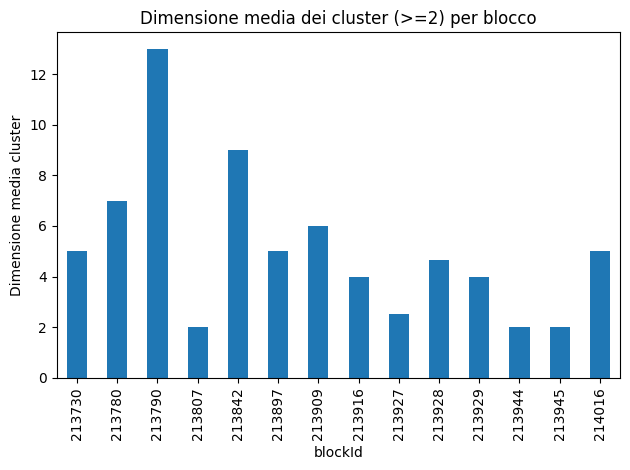

In [ ]:
#3 Calcola la dimensione media dei cluster per ogni blocco, considerando solo cluster con almeno 2 indirizzi
if not all_clusters.empty:
    # Filtra prima i cluster con almeno 2 indirizzi
    filtered = all_clusters[all_clusters['num_addresses'] >= 2]
    
    # Calcola la media per blocco
    avg_cluster_size_per_block = filtered.groupby('blockId')['num_addresses'].mean().reset_index()

    if not avg_cluster_size_per_block.empty:
        print("Dimensione media dei cluster (>=2) per blocco:")
        # print(avg_cluster_size_per_block)
        
        # Grafico
        plt.figure(figsize=(12, 6))
        avg_cluster_size_per_block.plot(kind='bar', x='blockId', y='num_addresses', legend=False)
        plt.title('Dimensione media dei cluster (>=2) per blocco')
        plt.xlabel('blockId')
        plt.ylabel('Dimensione media cluster')
        plt.tight_layout()
        plt.show()
    else:
        print("Nessun cluster con almeno 2 indirizzi trovato.")
else:
    print("Nessun cluster disponibile per il calcolo.")

#### 4) Discussion about
